In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# CIFAR10 datasets를 통해서 해당 데이터를 분류하는 모델을 만든다.

In [2]:
%config Completer.use_jedi = False

In [3]:
# cifar10 dataset을 통해 classification model을 tensorflow.keras.layerskeras.datasets import cifar10
from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape)
print(train_labels.shape)

2024-02-11 11:41:19.874637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 11:41:19.874735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 11:41:20.190159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(50000, 1)


In [4]:
# 첫번째 이미지에 대한 정보 확인

print(train_images[0,:,:])
print(train_labels[0,:])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
[6]


In [5]:
# train_labels 10개 출력
NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
# print(train_labels[:10])

for i in range(10):
    print(train_labels[i])
    print(NAMES[train_labels[i,0]])

[6]
frog
[9]
truck
[9]
truck
[4]
deer
[1]
automobile
[1]
automobile
[2]
bird
[7]
horse
[8]
ship
[3]
cat


### CIFAR10 데이터 시각화
* 이미지 크기는 32*32이며, RGB채널, 수식으로 표현하면 32*32*3
* 이미지를 보면 전반적으로 label에 해당하는 대상이 가운데에 있고, 그 이미지에서 label 대상의 비중이 크다

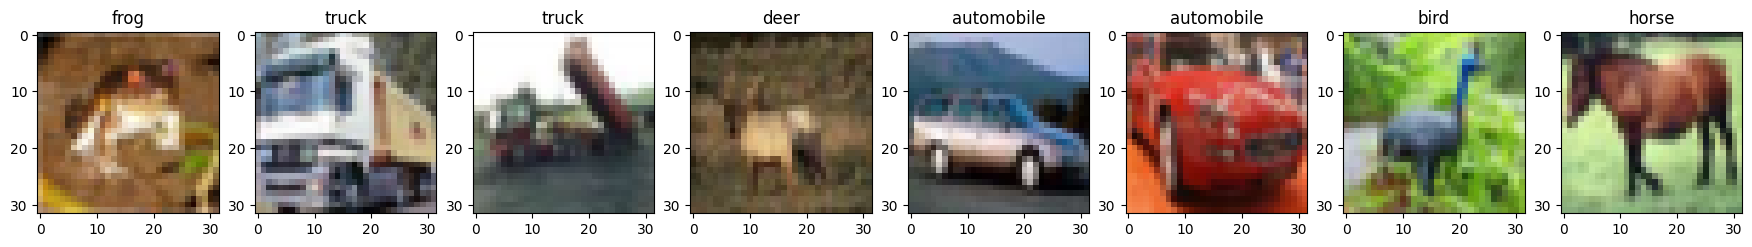

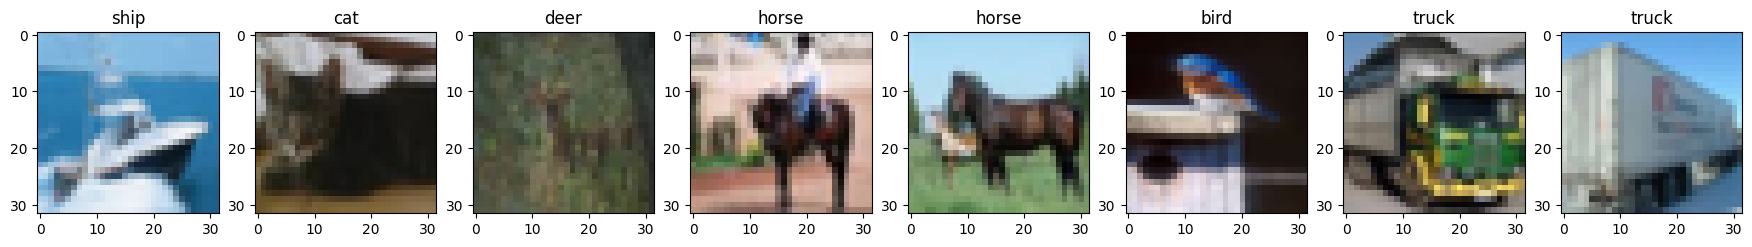

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22,6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze()  # 원래 labels가 2차원 데이터로 들어오는데 이걸 1차원으로 축소
        axs[i].set_title(NAMES[int(label)])

show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

### data preprocessing
* iamge array의 0 ~ 255 사이의 값으로 되어 있는 pixel intensity 값을 0 ~ 1 사이 값으로 변환. 각 pixel을 255.0으로 나눈다.
* label array는 숫자형 값으로 바꾸고 이후 one hot encoding을 적용할지 선택한다. 이번 모델은 one hot encoding을 적용하지 않는다.
* image array, label array 모두 np.float32로 형변환. np.float32는 tensor 변환시 tf.float32로 변환되어 기본적으로 tensorflow backend keras는 tf.float32를 기반으로 한다.

In [7]:
# label은 one hot encoding이 keras에서 활용이 용이하나 이번에는 sparse categorical crossentropy를 사용해보기 위해 적용하지 않는다.

def get_preprocessed_data(images, labels):
    
    # 학습과 테스트 이미지 array를 0 ~ 1 사잇값으로 scale 및 float32로 변환
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

train_images, train_labels = get_preprocessed_data(train_images, train_labels)
test_images, test_labels = get_preprocessed_data(test_images, test_labels)

In [8]:
# 전처리 적용 여부 확인
train_images[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [9]:
# keras는 CNN 2D 모델에 학습 데잍터 입력 시 반드시 image array는 4차원 배열이 되어야 한다.
# rgb 채널 이미지 array는 기본적으로 3차원인데 여기서 이미지의 개수를 포함해서 4차원이 형성되는 구조다.
# 만일 grayscale이 2차원 이미지 array라고 해도 의도적으로 채널을 명시해서 3차원으로 만들어 이미지 개수를 포함하면 4차원이 되도록 해야한다.

print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 1)


In [10]:
# labels 데이터가 2차원임. 이를 keras 모델에 입력해도 문제없이 작동한다.
# 그치만 one hot encoding의 적용 여부를 명확하게 알 수 있게 1차원으로 만들어주자

train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

print(train_labels.shape)
print(test_labels.shape)

(50000,)
(10000,)


### Model 생성
* CNN Model의 첫 layer에는 input_layer을 넣고 shape는 이미지 사이즈에 맞게 설정
* conv 연산을 적용하고 maxpooling을 적용. maxpooling 적용 후에는 필터 개수를 증가시킴
* maxpooling 이후 feature map 사이즈는 작아지지만 채널(깊이)은 늘어나는 형태.
* CIFAR10의 Label수가 10개이므로 Classification을 위한 맨 마지막 Dense layer의 units 갯수는 10개임
* label값이 원-핫 인코딩 되지 않았기 때문에 model.compile()에서 loss는 반드시 sparse_categorical_crossentropy여야함.

In [11]:
IMAGE_SIZE = 32

In [12]:
# 이미지 자체 사이즈가 3*3으로 크지 않아서 kernel_size를 지나치게 크게 잡을 필요가 없다.
# 초기 receptive_field 크기 설정에 대해서 정해진 법칙은 없고 돌려보면서 확인해야 한다.

from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)  # 이런식으로 conv2d와 activation을 별개로 적용할 수 있다.
x = MaxPooling2D(2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(2)(x)

# cifar의 클라스가 10개니까 마지막 layer의 unit 개수는 10개
x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                             

In [13]:
# optimizer는 Adam으로 설정하고 label 값이 one hot encoding이 아니니까 loss는 sparse cateorical crossentropy
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Model 학습 수행 및 테스트 데이터로 평가
* Model의 fit 메소드를 호출해 학습
* fit은 학습 데이터가 np array 형태로 들어올 때랑 Generator 형태로 들어올 때 약간의 차이가 있음
* batch_size는 한번에 가져올 image label array 개수. 수가 너무 작으면 시간이 오래 걸리고 너무 크면 gpu memory 부족이 발생할 수 있어 적절한 batch size 설정이 필요. 단, 학습 데이터가 generator인 경우 

In [14]:
model_fit = model.fit(x=train_images, y = train_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30


I0000 00:00:1707651713.576695      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


665/665 [==============================] - 15s 9ms/step - loss: 1.6996 - accuracy: 0.3668 - val_loss: 1.4165 - val_accuracy: 0.4891
Epoch 2/30
665/665 [==============================] - 5s 7ms/step - loss: 1.2219 - accuracy: 0.5597 - val_loss: 1.0210 - val_accuracy: 0.6379
Epoch 3/30
665/665 [==============================] - 5s 7ms/step - loss: 1.0015 - accuracy: 0.6454 - val_loss: 0.9175 - val_accuracy: 0.6773
Epoch 4/30
665/665 [==============================] - 5s 7ms/step - loss: 0.8605 - accuracy: 0.6930 - val_loss: 0.7959 - val_accuracy: 0.7163
Epoch 5/30
665/665 [==============================] - 5s 7ms/step - loss: 0.7663 - accuracy: 0.7284 - val_loss: 0.7265 - val_accuracy: 0.7431
Epoch 6/30
665/665 [==============================] - 5s 7ms/step - loss: 0.6935 - accuracy: 0.7548 - val_loss: 0.6783 - val_accuracy: 0.7644
Epoch 7/30
665/665 [==============================] - 5s 7ms/step - loss: 0.6307 - accuracy: 0.7782 - val_loss: 0.7837 - val_accuracy: 0.7283
Epoch 8/30
665/6

In [15]:
model_fit.history

{'loss': [1.6996448040008545,
  1.2218893766403198,
  1.0015435218811035,
  0.8605448603630066,
  0.7663147449493408,
  0.6934975981712341,
  0.6307488679885864,
  0.5935016870498657,
  0.5527864694595337,
  0.5089660882949829,
  0.4825354218482971,
  0.45680540800094604,
  0.42724645137786865,
  0.4206429123878479,
  0.39925146102905273,
  0.37091466784477234,
  0.36924123764038086,
  0.34942424297332764,
  0.33339712023735046,
  0.32099461555480957,
  0.3130233585834503,
  0.30767935514450073,
  0.29295846819877625,
  0.2949507236480713,
  0.28416165709495544,
  0.27633920311927795,
  0.2737971842288971,
  0.25897324085235596,
  0.27540943026542664,
  0.2556286156177521],
 'accuracy': [0.366752952337265,
  0.5597176551818848,
  0.6454117894172668,
  0.6929882168769836,
  0.7283764481544495,
  0.754800021648407,
  0.7782353162765503,
  0.7894352674484253,
  0.805082380771637,
  0.8196470737457275,
  0.8314823508262634,
  0.8368706107139587,
  0.8502588272094727,
  0.8519999980926514,


313/313 [==============================] - 1s 3ms/step - loss: 0.7499 - accuracy: 0.7878


[0.7498961091041565, 0.7878000140190125]

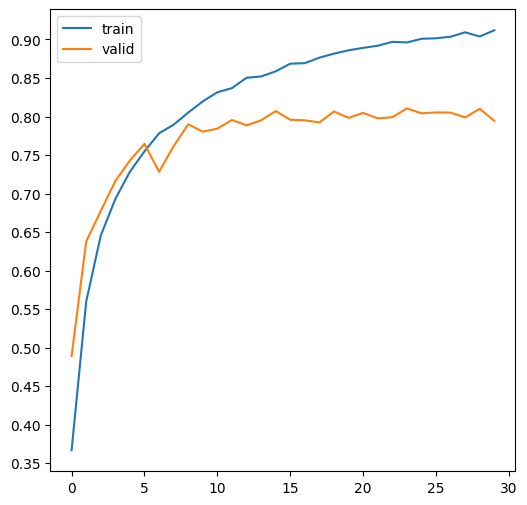

In [16]:
# 결과를 보면 알겠지만 오버피팅의 경향을 보이고 있음

import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6,6))
    plt.yticks(np.arange(0,1, 0.05))
    plt.plot(model_fit.history['accuracy'], label='train')
    plt.plot(model_fit.history['val_accuracy'], label='valid')
    plt.legend()

show_history(model_fit)

model.evaluate(test_images, test_labels)

### model.predict()를 통해 이미지 분류 예측
* 4차원 이미지 배열을 입력해서 모델학습을 하는 경우, predict시에도 4차원 이미지 배열을 입력해야 한다.
* 학습 데이터의 원-핫 인코딩 적용 여부와 관계없이 softmax 적용 결과는 무조건 2차원이 나오므로 이에 유의하자.

In [17]:
# 아래 코드는 Conv2D를 사용한 모델에 4차원 이미지 배열을 입력해야 하는데 3차원 이미지 배열을 넣어서 오류 발생
# 개별 이미지를 사용하는 경우 3차원 데이터가 model에 입력되므로 오류 발생

test_images[0].shape  # 3차원 배열

# preds = model.predict(test_images[0])

(32, 32, 3)

In [18]:
# 테스트용 4차원 이미지 배열을 입력해서 predict 수행
# predict의 결과는 softmax 적용 결과다 
# 이는 학습 데이터의 원-핫 인코딩 적용 여부와 관계없이 softmax 적용 결과는 무조건 2차원이다.

preds = model.predict(np.expand_dims(test_images[0], axis=0))
print('예측 결과 shape', preds.shape)
print('예측 결과', preds)

1/1 [==============================] - 1s 607ms/step
예측 결과 shape (1, 10)
예측 결과 [[8.2880242e-06 2.3865106e-05 3.0975477e-03 4.8053971e-01 5.3890280e-06
  4.5443249e-01 4.6934844e-03 1.9285116e-04 5.6996591e-02 9.8041628e-06]]


In [19]:
print(test_images[:16].shape) # (16, 32, 32, 3)

preds = model.predict(test_images[:32], batch_size=32)
print(preds.shape)
print(preds)

(16, 32, 32, 3)
1/1 [==============================] - 0s 19ms/step
(32, 10)
[[8.28794236e-06 2.38648718e-05 3.09754396e-03 4.80538666e-01
  5.38902168e-06 4.54433024e-01 4.69347043e-03 1.92849475e-04
  5.69970533e-02 9.80406730e-06]
 [1.92737289e-07 9.12294781e-05 1.80550460e-14 1.08916130e-14
  3.24638550e-18 7.06521596e-18 3.13301118e-15 1.04977802e-18
  9.99908566e-01 4.10299137e-08]
 [1.40129887e-02 5.57148457e-02 4.18521371e-03 3.06581378e-01
  8.11351463e-04 4.13411157e-03 1.96035560e-02 1.31891924e-03
  5.54012299e-01 3.96253020e-02]
 [9.41847920e-01 1.61319658e-05 1.93053653e-04 2.33130140e-05
  7.35748316e-08 1.31246281e-09 2.17561369e-09 6.59648602e-09
  5.78579940e-02 6.15090103e-05]
 [3.99575872e-10 4.95553643e-08 3.35141714e-03 1.00211633e-04
  7.71796505e-04 1.10539018e-08 9.95776474e-01 1.71794801e-10
  1.85518767e-09 1.12379550e-09]
 [6.69886276e-07 8.26987616e-07 4.28833970e-04 1.42968930e-02
  1.10948668e-03 3.58540029e-03 9.80550647e-01 4.11889278e-06
  9.50431058e-

In [20]:
predicted_class = np.argmax(preds, axis=1)
print('예측 클래스 값',predicted_class)

예측 클래스 값 [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 3 8 6 7 0 4 9 4 2 2 0 9 6 6 5]


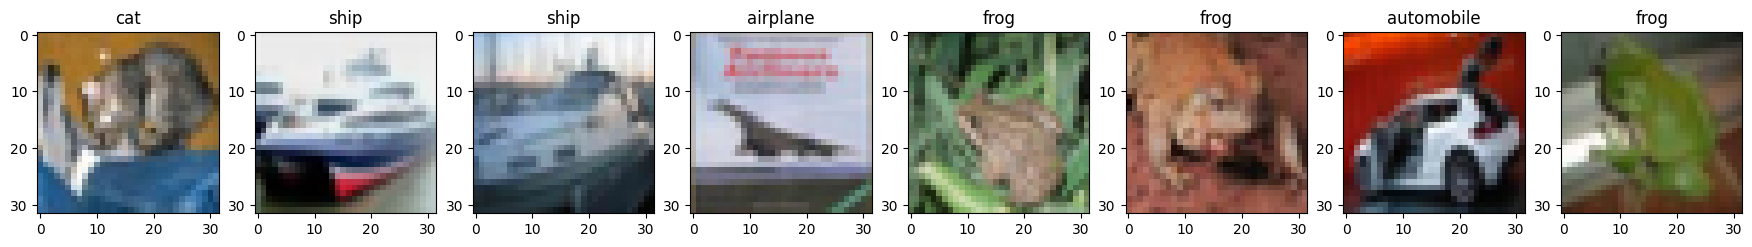

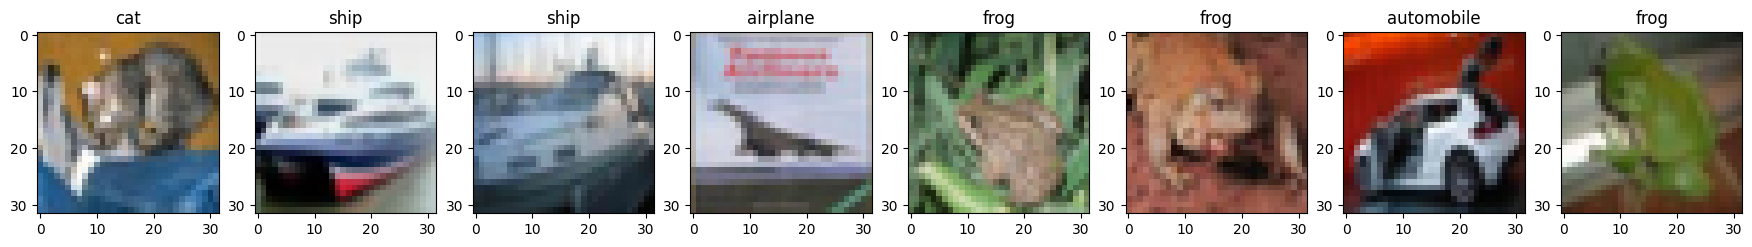

In [21]:
show_images(test_images[:8], predicted_class[:8], ncols=8)
show_images(test_images[:8], test_labels[:8], ncols=8)

## weight 초기화
* 좋은 weight 초기화 조건은 아래와 같다.
    1. 값이 동일하지 않다.
    2. 충분히 작아야 한다. / 안 그러면 x1w11 + x2w12..의 연산 과정에서 값이 지나치게 커진다
    3. 적당한 분산(혹은 표준편차)를 가져야 한다.
* 이를 위해 시용되는 초기화 식으론 Xavier Initialization, He Initialization 등이 있다.

### Xavier initialization / 정규분포(glorot_normal), 균일분포(glorot_uniform)
* Xavier initialization은 주로 비선형함수(sigmoid, tanh 등)에서 효과적이다.
* 하지만 ReLU함수에 있어선 사용 시 출력 값이 0으로 수렴하는 현상이 있어 다른 방법이 필요하다.

In [22]:
# glorot_normal

fan_in = 20
fan_out = 15
scale_value = np.sqrt(2/(fan_in + fan_out))
print('scale:', scale_value)
weights = np.random.normal(loc=0.0, scale=scale_value, size=(100,100))
print(weights)
print('weights mean:', weights.mean(), 'std:', weights.std(), 'sum:', weights.sum())

scale: 0.23904572186687872
[[-0.06919739  0.36707002 -0.10998738 ... -0.04193542 -0.01667868
   0.11310325]
 [-0.33106873 -0.08168819  0.15702418 ...  0.10383956  0.02697545
  -0.20043788]
 [-0.18505399 -0.36003211 -0.14482995 ... -0.5041876   0.00913068
   0.25406121]
 ...
 [ 0.16374962 -0.34336205  0.08070122 ...  0.14800316  0.19043019
  -0.15857464]
 [-0.65475809  0.07897271  0.0289208  ... -0.35377216  0.39992246
   0.07265323]
 [-0.3844027  -0.16095542  0.08566289 ... -0.16621559  0.11787034
  -0.06482576]]
weights mean: 0.0001944272012522223 std: 0.2401027056589497 sum: 1.944272012522223


In [23]:
# glorot_uniform

fan_in = 10
fan_out = 8
limit = np.sqrt(6/(fan_in + fan_out))
print('limit:', limit)
weights = np.random.uniform(-1*limit, limit, size=(100, 100))
print(weights)
print('weights mean:',weights.mean(), 'std:', weights.std(), 'sum:', weights.sum())

limit: 0.5773502691896257
[[-0.40321562 -0.10467071 -0.3479157  ...  0.26851748 -0.3691282
  -0.02510709]
 [ 0.55344402  0.07779156 -0.49368671 ...  0.33242902  0.49301246
   0.28919736]
 [ 0.42690842  0.19981963  0.56992606 ... -0.18885676 -0.52715662
   0.04654065]
 ...
 [-0.03381033 -0.33225855 -0.28656369 ... -0.18087637 -0.19140941
  -0.02336697]
 [-0.08111956 -0.44011085  0.35823992 ...  0.26558565 -0.47910582
  -0.44777258]
 [-0.18509403  0.36177604 -0.54018961 ... -0.34420986 -0.14376803
   0.42203459]]
weights mean: -0.0029040611483657905 std: 0.3320304079764077 sum: -29.040611483657905


### He initialization - 정규분포(he_normal), 균일분포(he_uniform)
* He initialization의 경우 ReLu 함수 사용 시 weights를 초기화에 적합하다.

In [24]:
fan_in = 10
fan_out = 8
scale_value = np.sqrt(2/(fan_in))
print('scale:', scale_value)
weights = np.random.normal(loc=0.0, scale=scale_value, size=(100, 100))
print(weights)
print('weights mean:',weights.mean(), 'std:', weights.std(), 'sum:', weights.sum())

scale: 0.4472135954999579
[[ 0.40707487  0.05691167  0.65653097 ... -1.19814272  0.03582729
  -0.02081572]
 [ 0.17653638  0.64578259 -0.12416023 ...  0.33381882 -0.39980104
  -0.3072784 ]
 [-0.11472883  0.53138808 -0.25410245 ... -0.6379534  -0.16829008
   0.54562428]
 ...
 [-0.50098348 -0.21813389  0.65969812 ... -0.24067931 -0.85606019
   0.44807401]
 [ 0.27357723 -0.53898115  0.83493827 ...  0.08001409 -0.03956233
  -0.44938959]
 [-0.15291784 -0.59446709 -0.37863487 ...  0.11078869  0.31160872
  -0.02176771]]
weights mean: -0.00026000744815153214 std: 0.4474482986995441 sum: -2.600074481515321


In [25]:
fan_in = 10
fan_out = 8
limit = np.sqrt(6/(fan_in))
print('limit:', limit)
weights = np.random.uniform(-1*limit, limit, size=(100,100))
print(weights)
print('weights mean:', weights.mean(),'std:', weights.std(), 'sum:', weights.sum())

limit: 0.7745966692414834
[[ 0.75247984  0.63929234  0.22434653 ... -0.42696613  0.6897765
   0.76653365]
 [ 0.56302351 -0.19655072  0.65056188 ... -0.2529411  -0.33844929
  -0.58336689]
 [-0.39908593  0.27867026  0.35665048 ...  0.080006    0.51101697
  -0.14135332]
 ...
 [-0.53357157 -0.53324795 -0.38736036 ...  0.03914204  0.64838103
   0.44595893]
 [ 0.76090698  0.27780651  0.06745229 ...  0.47130553  0.38587792
  -0.55796604]
 [-0.50330468  0.54910451 -0.18885652 ... -0.00405555  0.03803904
  -0.45701261]]
weights mean: -0.0001169448892562226 std: 0.44808045420277665 sum: -1.169448892562226


### weight 초기화를 He Normal로 변경 후 테스트
* keras conv2d의 기본 weights 초기화는 glorot_uniform인데, 이를 he_normal로 변경 후 동일 모델로 성능 검증
* label의 경우 one hot encoding 적용

In [26]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def get_preprocessed_data(images, labels):
    
    # 학습과 테스트 이미지 array를 0~1 사잇값으로 scale 및 float32로 타입 변환
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    labels = labels.squeeze()
    
    return images, labels

def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    # ohe 적용
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
print(train_images.shape, train_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [27]:
IMAGE_SIZE=32

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(input_tensor)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D(pool_size=2)(x)

# cifar10의 클래스가 10개라 마지막 classification의 dense layer units 개수는 10개
x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax')(x)

kernel_initialized_model = Model(inputs=input_tensor, outputs=output)

kernel_initialized_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                           

In [29]:
kernel_initialized_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = kernel_initialized_model.fit(x=train_images, y=train_oh_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 9s 9ms/step - loss: 1.6131 - accuracy: 0.4076 - val_loss: 1.2912 - val_accuracy: 0.5265
Epoch 2/30
665/665 [==============================] - 6s 8ms/step - loss: 1.1498 - accuracy: 0.5901 - val_loss: 0.9689 - val_accuracy: 0.6471
Epoch 3/30
665/665 [==============================] - 6s 9ms/step - loss: 0.9512 - accuracy: 0.6630 - val_loss: 0.8655 - val_accuracy: 0.7024
Epoch 4/30
665/665 [==============================] - 6s 9ms/step - loss: 0.8315 - accuracy: 0.7059 - val_loss: 0.7468 - val_accuracy: 0.7395
Epoch 5/30
665/665 [==============================] - 6s 9ms/step - loss: 0.7498 - accuracy: 0.7397 - val_loss: 0.7631 - val_accuracy: 0.7367
Epoch 6/30
665/665 [==============================] - 6s 9ms/step - loss: 0.6765 - accuracy: 0.7604 - val_loss: 0.6778 - val_accuracy: 0.7668
Epoch 7/30
665/665 [==============================] - 6s 8ms/step - loss: 0.6276 - accuracy: 0.7785 - val_loss: 0.6739 - val_accuracy: 0.7693
Epoch 

313/313 [==============================] - 1s 3ms/step - loss: 0.7642 - accuracy: 0.7876


[0.7642046809196472, 0.7875999808311462]

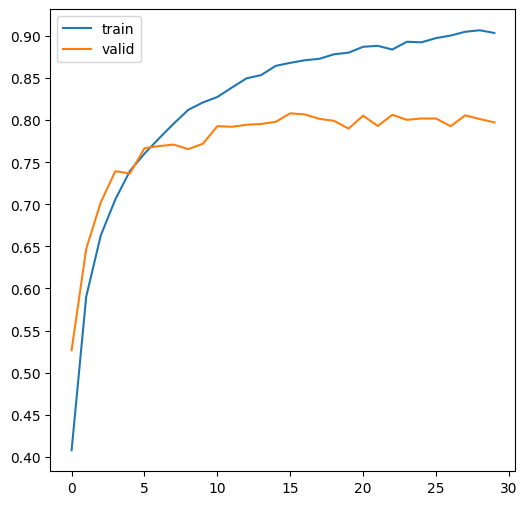

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6,6))
    plt.yticks(np.arange(0,1, 0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

show_history(history)

# 테스트 데이터로 성능 평가
kernel_initialized_model.evaluate(test_images, test_oh_labels)

### Batch Normalization 적용
* internal covariate shift 해결(신경망 내부 각 층을 통과하면서 입력 데이터 분포가 조금씩 달라지는 현상)

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

input_tensor= Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=3, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax')(x)

batch_normalized_model = Model(inputs=input_tensor, outputs=output)

batch_normalized_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                          

In [32]:
batch_normalized_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = batch_normalized_model.fit(x=train_images, y=train_oh_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 11s 11ms/step - loss: 1.6012 - accuracy: 0.4245 - val_loss: 1.4356 - val_accuracy: 0.4755
Epoch 2/30
665/665 [==============================] - 6s 9ms/step - loss: 1.1336 - accuracy: 0.5965 - val_loss: 1.5977 - val_accuracy: 0.4935
Epoch 3/30
665/665 [==============================] - 6s 9ms/step - loss: 0.9401 - accuracy: 0.6699 - val_loss: 1.0475 - val_accuracy: 0.6436
Epoch 4/30
665/665 [==============================] - 6s 9ms/step - loss: 0.8056 - accuracy: 0.7190 - val_loss: 1.1890 - val_accuracy: 0.6107
Epoch 5/30
665/665 [==============================] - 6s 9ms/step - loss: 0.7305 - accuracy: 0.7456 - val_loss: 0.7270 - val_accuracy: 0.7457
Epoch 6/30
665/665 [==============================] - 6s 9ms/step - loss: 0.6551 - accuracy: 0.7736 - val_loss: 0.8356 - val_accuracy: 0.7288
Epoch 7/30
665/665 [==============================] - 6s 9ms/step - loss: 0.6038 - accuracy: 0.7927 - val_loss: 0.7379 - val_accuracy: 0.7471
Epoc

313/313 [==============================] - 2s 4ms/step - loss: 0.6328 - accuracy: 0.8371


[0.6328340768814087, 0.8371000289916992]

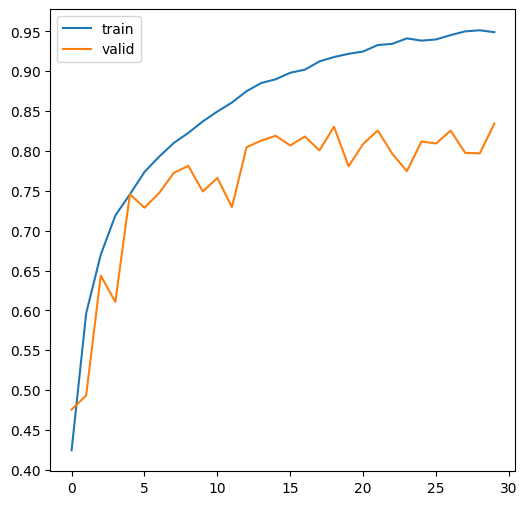

In [33]:
show_history(history)

batch_normalized_model.evaluate(test_images, test_oh_labels)

### He Normal Batch Normalization 동시 적용

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                          

In [35]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=train_images, y=train_oh_labels, batch_size=64, epochs=30, validation_split=0.15)

Epoch 1/30
665/665 [==============================] - 10s 10ms/step - loss: 1.6127 - accuracy: 0.4147 - val_loss: 1.6850 - val_accuracy: 0.4509
Epoch 2/30
665/665 [==============================] - 6s 9ms/step - loss: 1.1533 - accuracy: 0.5854 - val_loss: 1.0454 - val_accuracy: 0.6255
Epoch 3/30
665/665 [==============================] - 6s 9ms/step - loss: 0.9489 - accuracy: 0.6653 - val_loss: 1.0713 - val_accuracy: 0.6324
Epoch 4/30
665/665 [==============================] - 6s 9ms/step - loss: 0.8286 - accuracy: 0.7112 - val_loss: 0.9830 - val_accuracy: 0.6612
Epoch 5/30
665/665 [==============================] - 6s 9ms/step - loss: 0.7457 - accuracy: 0.7412 - val_loss: 0.9345 - val_accuracy: 0.6944
Epoch 6/30
665/665 [==============================] - 6s 9ms/step - loss: 0.6649 - accuracy: 0.7704 - val_loss: 0.8286 - val_accuracy: 0.7117
Epoch 7/30
665/665 [==============================] - 6s 9ms/step - loss: 0.6096 - accuracy: 0.7898 - val_loss: 0.6227 - val_accuracy: 0.7845
Epoc

313/313 [==============================] - 1s 4ms/step - loss: 0.7612 - accuracy: 0.8080


[0.7611597776412964, 0.8080000281333923]

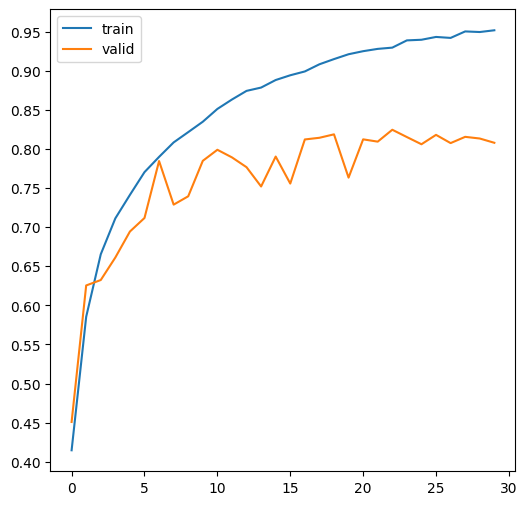

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6,6))
    plt.yticks(np.arange(0,1, 0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

show_history(history)

model.evaluate(test_images, test_oh_labels)

# Global Average Pooling 적용
* global average pooling은 feature map의 가로x세로의 특정 영역을 sub sampling하지 않고 채널별로 평균 값을 추출한다.
* GAP를 적용하는 이유는 기존 flatten에서 Classification Dense Layer로 넘어가는 과정에서 지나치게 많은 파라미터들로 인한 오버피팅 가능성이 높아지고, 많은 파라미터로 인해 연산량이 지나치게 많아 시간이 오래 걸린다.
* 충분히 feature map의 채널수가 많은 경우 GAP를 적용하고, 채널수가 적다면 기존 flatten이 유라하다.
* 가장 마지막 feature map의 채널 수가 충분히 크다면 GlobalAveragePooling2D를 적용하는 것이 유리하다.

In [37]:
IMAGE_SIZE = 32

In [38]:
# global average pooling 적용을 위한 모델 생성

from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Activation, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# flatten 대신에 global average pooling을 적용
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_12 (Ba  (None, 32, 32, 128)       512       
 tchNormalization)                                               
                                                                 
 activation_17 (Activation)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 activation_18 (Activation)  (None, 32, 32, 128)       0         
                                                           

In [39]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration 내에 validation loss가 좋아지지 않으면 learning rate를 learning * factor로 변경
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)

# 10번 iteration 내로 validation loss가 좋아지지 않으면 학습 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(x=train_images, y=train_oh_labels, batch_size=32, epochs=30, 
                   validation_split=0.15, callbacks=[rlr_cb, ely_cb])

Epoch 1/30
1329/1329 [==============================] - 36s 23ms/step - loss: 1.5046 - accuracy: 0.4421 - val_loss: 1.4127 - val_accuracy: 0.5183 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 28s 21ms/step - loss: 1.1190 - accuracy: 0.6013 - val_loss: 0.9465 - val_accuracy: 0.6595 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.9584 - accuracy: 0.6590 - val_loss: 1.1691 - val_accuracy: 0.5991 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.8550 - accuracy: 0.6971 - val_loss: 0.8043 - val_accuracy: 0.7073 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.7571 - accuracy: 0.7364 - val_loss: 1.1711 - val_accuracy: 0.6053 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.6722 - accuracy: 0.7687 - val_loss: 0.7388 - val_accuracy: 0.7451 - lr: 0.0010
Epoch 7/30
1329/1329 [========================

313/313 [==============================] - 3s 8ms/step - loss: 0.6123 - accuracy: 0.8620


[0.6123188734054565, 0.8619999885559082]

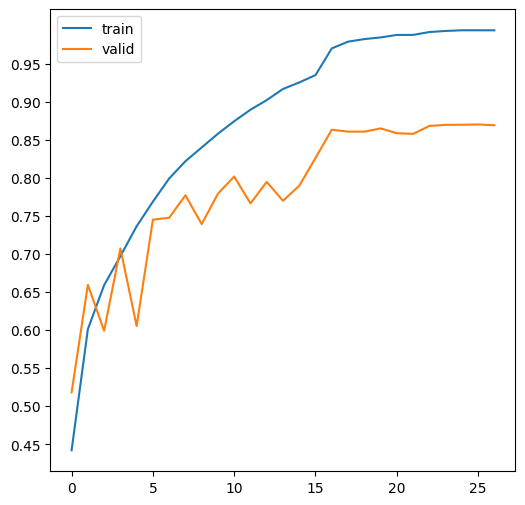

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6,6))
    plt.yticks(np.arange(0,1, 0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

show_history(history)

model.evaluate(test_images, test_oh_labels)

# Weight Regularization 적용
* 모델의 loss 값을 줄이는 것에만 치중하게 되면 가중치 값이 학습데이터에 대해서만 정교화되면서 overfitting 문제가 발생하기 쉽다.
* 이를 해결하기 위해 기존 loss 함수 출력값에 전체 가중치 행렬값의 제곱값에 일정 계수를 곱한 값을 더해서 loss 함수 출력값을 조정한다.
* layer별로 keras에서 제공하는 3가지 가중치 규제를 적용할 수 있다.
    1. l1: 가중치의 절댓값
    2. l2: 가중치의 제곱
    3. l1_l2: l1과 l2의 결합
* 다만 크게 효과가 없는 경우도 많고, 규제를 강하게 걸면 오히려 성능이 떨어지는 경우도 있으니 경험적으로 돌려보고 판단해야 한다.

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.regularizers import l1, l2, l1_l2

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 512 filters Conv layer 추가하되 이후 MaxPooling을 적용하지 않고 strides는 2로 변경하여 출력 feature map 크기 조정
x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', kernel_regularizer=l2(1e-5), name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_16 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_23 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_17 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                         

In [42]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


history = model.fit(x=train_images, y=train_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_split=0.15,  
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/30
1329/1329 [==============================] - 26s 15ms/step - loss: 1.6378 - accuracy: 0.4271 - val_loss: 1.9509 - val_accuracy: 0.3869 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 19s 14ms/step - loss: 1.1942 - accuracy: 0.5984 - val_loss: 1.1420 - val_accuracy: 0.6212 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 19s 14ms/step - loss: 1.0202 - accuracy: 0.6716 - val_loss: 1.0633 - val_accuracy: 0.6623 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 19s 14ms/step - loss: 0.9136 - accuracy: 0.7196 - val_loss: 0.9886 - val_accuracy: 0.6868 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 19s 14ms/step - loss: 0.8373 - accuracy: 0.7546 - val_loss: 0.9213 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 19s 14ms/step - loss: 0.7733 - accuracy: 0.7855 - val_loss: 0.8580 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 7/30
1329/1329 [========================

313/313 [==============================] - 2s 6ms/step - loss: 1.0040 - accuracy: 0.8633


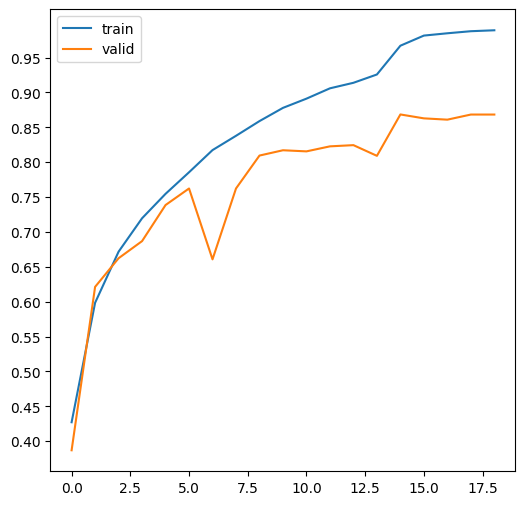

In [43]:
model.evaluate(test_images, test_oh_labels)
show_history(history)